# Extracting Haralick Features

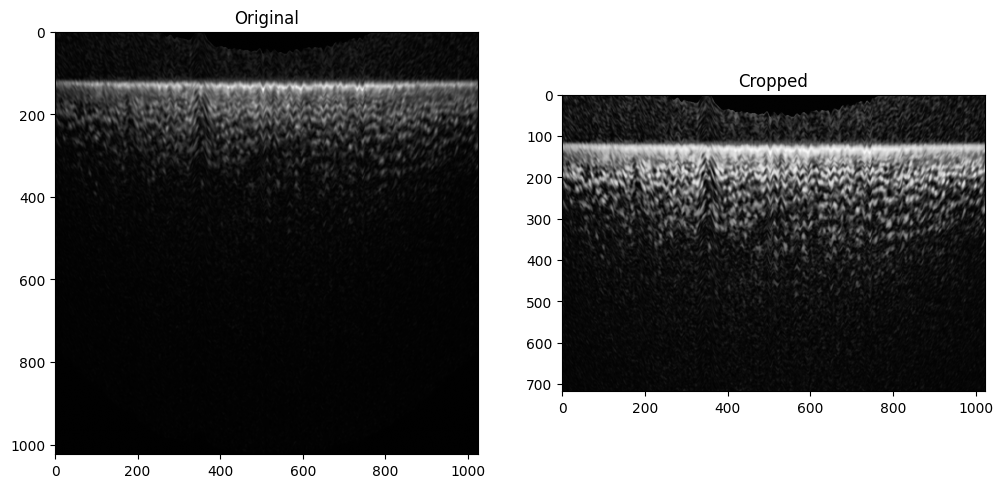


HARalick Features (Mean per direction):

ASM (Energy)                       : 0.0056
Contrast                           : 69.6047
Correlation                        : 0.9874
Variance                           : 2751.0995
IDM (Homogeneity)                  : 0.3169
Sum Average                        : 82.0947
Sum Variance                       : 10934.7934
Sum Entropy                        : 7.3980
Entropy                            : 10.3314
Difference Variance                : 0.0005
Difference Entropy                 : 3.6383
IMC1 (Info Measure Corr 1)         : -0.4028
IMC2 (Info Measure Corr 2)         : 0.9969


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import mahotas

# Cargar imagen en escala de grises
img = cv2.imread("C:/Users/ritaj/Documents/R/Rabanitos/imagenes/plain/OCTImage_2025_07_01_12-21-46.aligned.full.png", cv2.IMREAD_GRAYSCALE)

# Ecualización para mejorar el contraste
img_eq = exposure.equalize_adapthist(img / 255.0)
img_eq = (img_eq * 255).astype(np.uint8)

# Crear máscara ignorando zonas muy oscuras
threshold = 30
mask = img_eq > threshold
coords = np.column_stack(np.where(mask))
y0, x0 = coords.min(axis=0)
y1, x1 = coords.max(axis=0)

# Recorte
cropped_img = img_eq[y0:y1, x0:x1]

# Mostrar imagen original y recortada
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(cropped_img, cmap='gray')
plt.title("Cropped")
plt.show()

# Extraer HARalick features
features = mahotas.features.haralick(cropped_img).mean(axis=0)

# Nombres de las features HARalick
haralick_names = [
    "ASM (Energy)",
    "Contrast",
    "Correlation",
    "Variance",
    "IDM (Homogeneity)",
    "Sum Average",
    "Sum Variance",
    "Sum Entropy",
    "Entropy",
    "Difference Variance",
    "Difference Entropy",
    "IMC1 (Info Measure Corr 1)",
    "IMC2 (Info Measure Corr 2)"
]

# Mostrar nombres + valores
print("\nHARalick Features (Mean per direction):\n")
for name, value in zip(haralick_names, features):
    print(f"{name:35s}: {value:.4f}")



In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import exposure
import mahotas

# Ruta a la carpeta que contiene las imágenes
input_folder = "C:/Users/ritaj/Documents/R/Rabanitos/imagenes/plain"

# Lista para guardar resultados
data = []

# Nombres de las características Haralick
haralick_names = [
    "ASM (Energy)", "Contrast", "Correlation", "Variance", "IDM (Homogeneity)",
    "Sum Average", "Sum Variance", "Sum Entropy", "Entropy", "Difference Variance",
    "Difference Entropy", "IMC1 (Info Measure Corr 1)", "IMC2 (Info Measure Corr 2)"
]

# Procesar imágenes
for filename in os.listdir(input_folder):
    if filename.endswith(".png") and "full" not in filename:
        filepath = os.path.join(input_folder, filename)

        # Leer imagen en escala de grises
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error al cargar la imagen: {filename}")
            continue

        # Mejorar contraste (CLAHE)
        img_eq = exposure.equalize_adapthist(img / 255.0)
        img_eq = (img_eq * 255).astype(np.uint8)

        # Máscara para zonas relevantes
        threshold = 30
        mask = img_eq > threshold
        coords = np.column_stack(np.where(mask))

        if coords.size == 0:
            print(f"No se encontró región relevante en: {filename}")
            continue

        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
        cropped = img_eq[y0:y1, x0:x1]

        # Extraer características Haralick
        try:
            features = mahotas.features.haralick(cropped).mean(axis=0)
        except ValueError as e:
            print(f"Error calculando Haralick en {filename}: {e}")
            continue

        # Eliminar "aligned" del nombre de archivo
        clean_name = filename.replace("aligned.", "").replace("__", "_").strip("_")

        # Guardar resultados
        data.append([clean_name] + features.tolist())

# Crear DataFrame y guardar CSV
df = pd.DataFrame(data, columns=["Filename"] + haralick_names)
output_csv = os.path.join(input_folder, "haralick_features.csv")
df.to_csv(output_csv, index=False)

print(f"\n✅ Proceso completo. Features guardadas en: {output_csv}")



✅ Proceso completo. Features guardadas en: C:/Users/ritaj/Documents/R/Rabanitos/imagenes/plain\haralick_features2.csv


# Merging datasets

In [ ]:
import pandas as pd

# Rutas a los archivos Excel
features_path = "C:/Users/ritaj/Documents/R/Rabanitos/datasets/dataset1.xlsx"  # ← contiene individual, day, filename, features...
agua_path = "C:/Users/ritaj/Documents/R/Rabanitos/datasets/rzodkiewka_2025.xlsx"        # ← segunda hoja, con D1, D2, etc.

# --- 1. Leer archivo de % de agua (segunda hoja, saltando 3 filas) ---
df_agua_raw = pd.read_excel(agua_path, sheet_name=1, skiprows=3)

# Renombrar columnas: primera columna sin nombre → 'individual', el resto quitar 'D'
cols = df_agua_raw.columns.tolist()
cols[0] = "individual"
cols[1:] = [str(col)[1:] if isinstance(col, str) else col for col in cols[1:]]
df_agua_raw.columns = cols

# Convertir a formato largo (una fila por día e individuo)
df_agua = df_agua_raw.melt(id_vars="individual", var_name="day", value_name="water_percentage")

# Convertir tipos
df_agua["day"] = df_agua["day"].astype(int)
df_agua["individual"] = df_agua["individual"].astype(str)

# --- 2. Leer archivo con features Haralick ---
df_features = pd.read_excel(features_path)

# Asegurar consistencia en columnas clave
df_features["day"] = df_features["day"].astype(int)
df_features["individual"] = df_features["individual"].astype(str)

# --- 3. Merge uno-a-muchos por 'individual' y 'day' ---
df_merged = pd.merge(df_features, df_agua, on=["individual", "day"], how="left")

# Reporte de integridad
missing = df_merged["water_percentage"].isnull().sum()
if missing > 0:
    print(f"⚠️ Hay {missing} imágenes sin porcentaje de agua asociado.")

# --- 4. Guardar resultado ---
df_merged.to_excel("C:/Users/ritaj/Documents/R/Rabanitos/datasets/dataset_completo.xlsx", index=False)
print("✅ Dataset combinado guardado como 'dataset_completo.xlsx'")



# Data description

🧩 Dataset dimensions: (1359, 19)

🔍 First rows:
   individual  day                             photo  \
0          20    1  OCTImage_2025_07_01_12-21-46.dcm   
1          20    1  OCTImage_2025_07_01_12-22-03.dcm   
2          20    1  OCTImage_2025_07_01_12-22-24.dcm   
3          20    1  OCTImage_2025_07_01_12-22-32.dcm   
4          20    1  OCTImage_2025_07_01_12-22-42.dcm   

                        __key__                          Filename  \
0  OCTImage_2025_07_01_12-21-46  OCTImage_2025_07_01_12-21-46.png   
1  OCTImage_2025_07_01_12-22-03  OCTImage_2025_07_01_12-22-03.png   
2  OCTImage_2025_07_01_12-22-24  OCTImage_2025_07_01_12-22-24.png   
3  OCTImage_2025_07_01_12-22-32  OCTImage_2025_07_01_12-22-32.png   
4  OCTImage_2025_07_01_12-22-42  OCTImage_2025_07_01_12-22-42.png   

   ASM (Energy)    Contrast  Correlation     Variance  IDM (Homogeneity)  \
0      0.000138  217.636964     0.965280  3134.614391           0.110276   
1      0.000224  106.666318     0.981903  2947.4

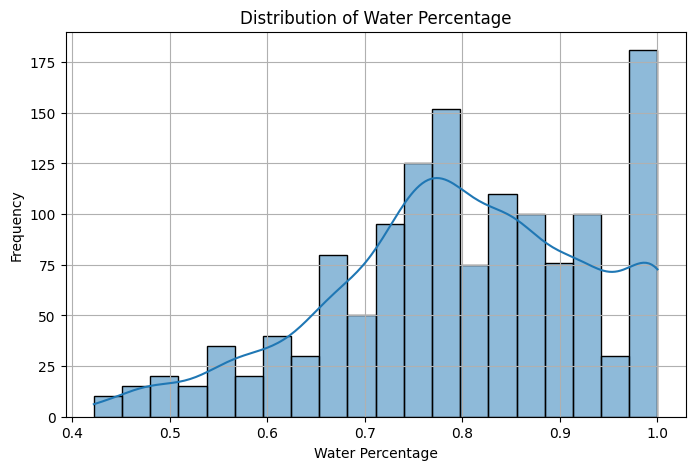

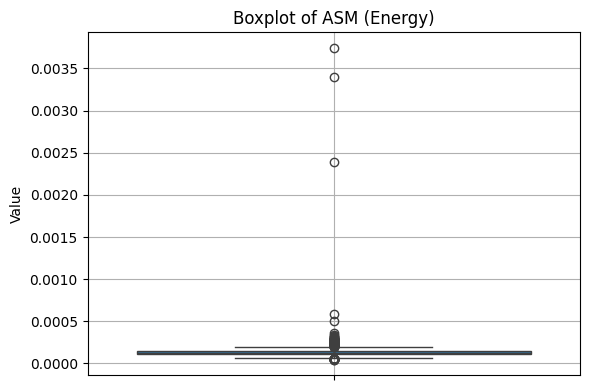

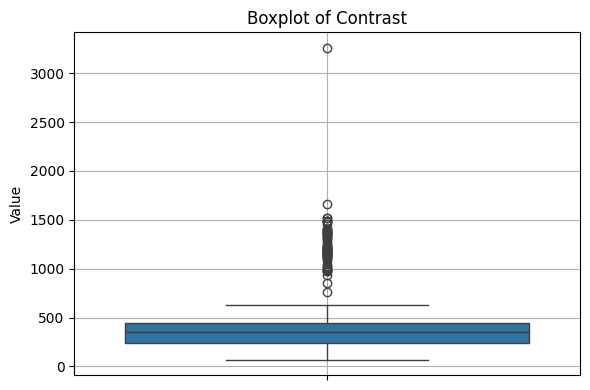

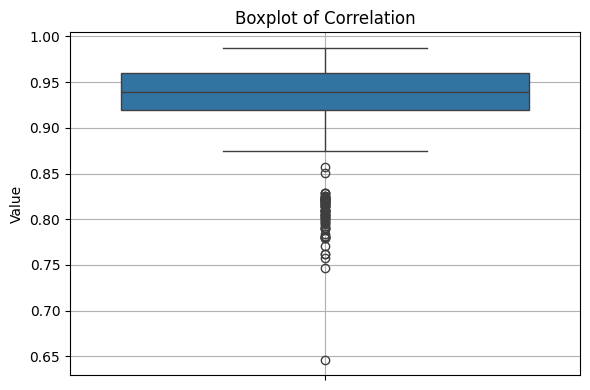

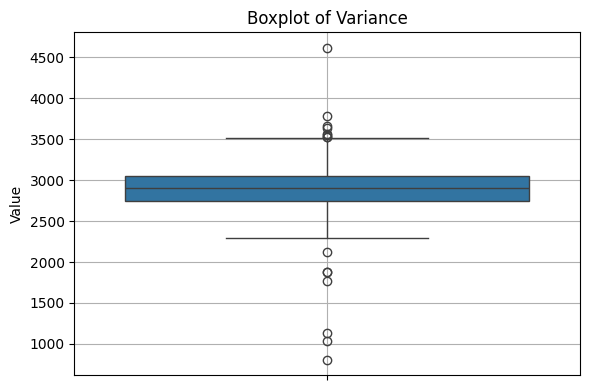

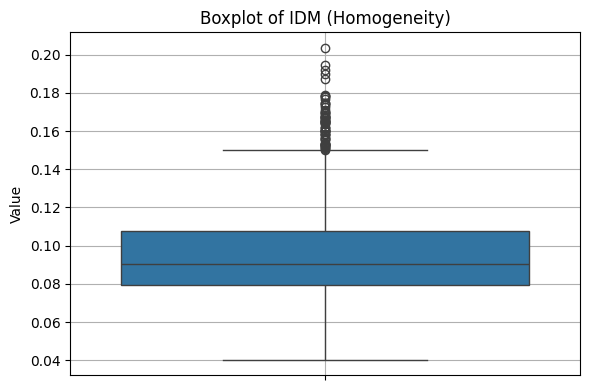

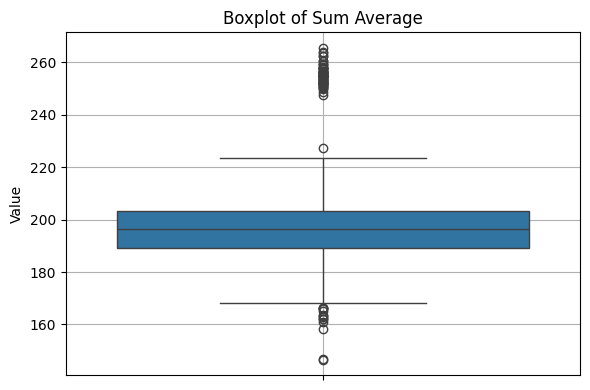

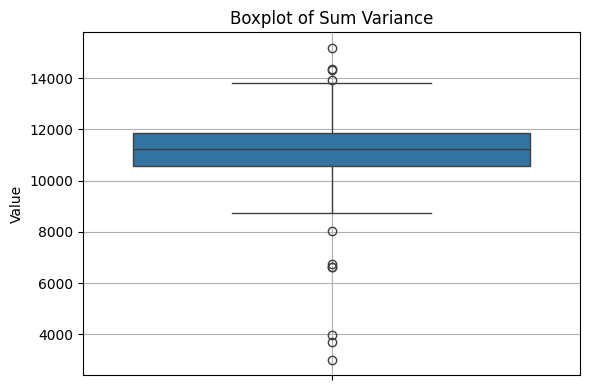

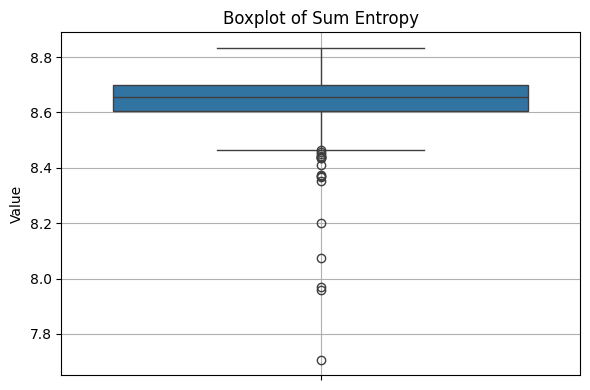

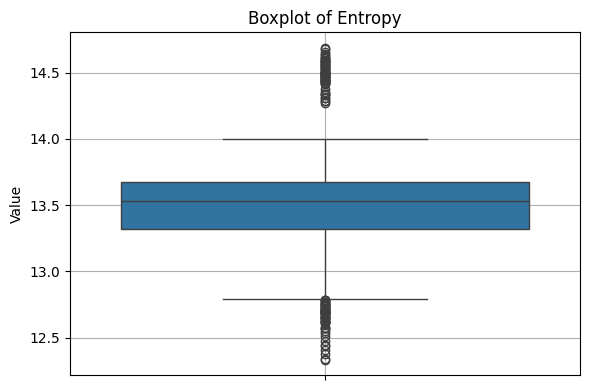

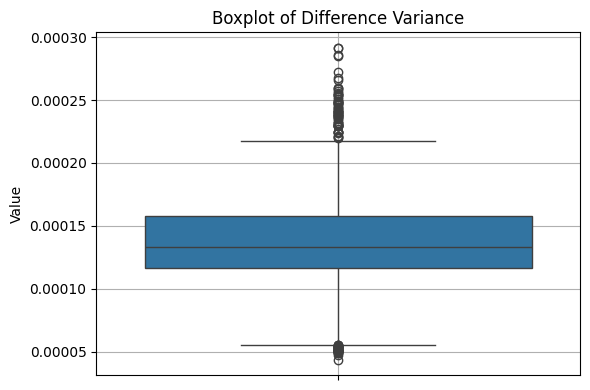

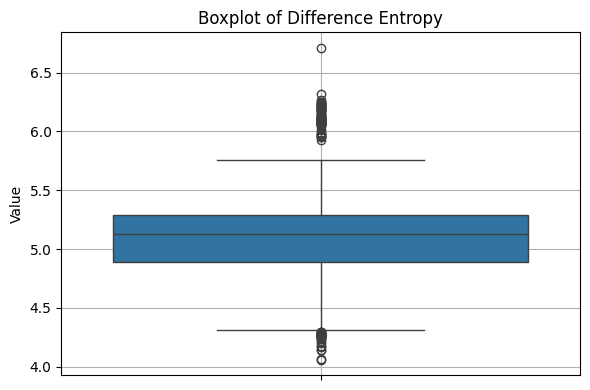

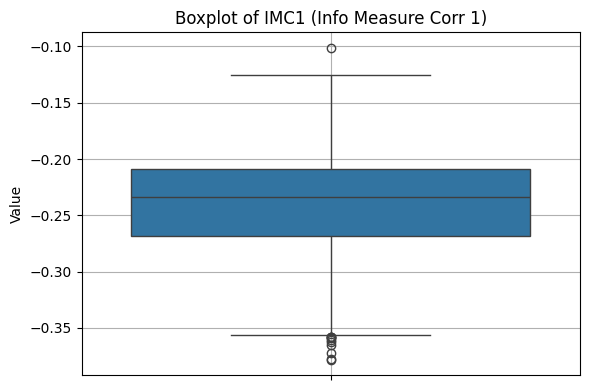

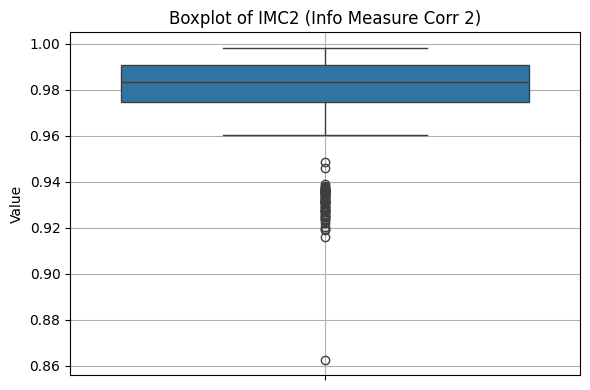


🚨 Number of outliers per Haralick feature (|Z| > 3):
ASM (Energy)                   3
Contrast                      55
Correlation                   52
Variance                      10
IDM (Homogeneity)             14
Sum Average                   67
Sum Variance                  10
Sum Entropy                    9
Entropy                       14
Difference Variance           11
Difference Entropy            16
IMC1 (Info Measure Corr 1)     0
IMC2 (Info Measure Corr 2)    60
dtype: int64

🔎 Total outlier rows (any Haralick feature): 93

🖼️ Outlier rows (including image names):
                              Filename  ASM (Energy)     Contrast  \
19    OCTImage_2025_07_04_14-41-33.png      0.000292    88.372224   
26    OCTImage_2025_07_08_13-31-30.png      0.000357    89.295937   
53    OCTImage_2025_07_03_09-13-02.png      0.000292    82.654428   
55    OCTImage_2025_07_04_15-31-00.png      0.000271    96.148404   
123   OCTImage_2025_07_01_12-33-12.png      0.000332    70.235752   

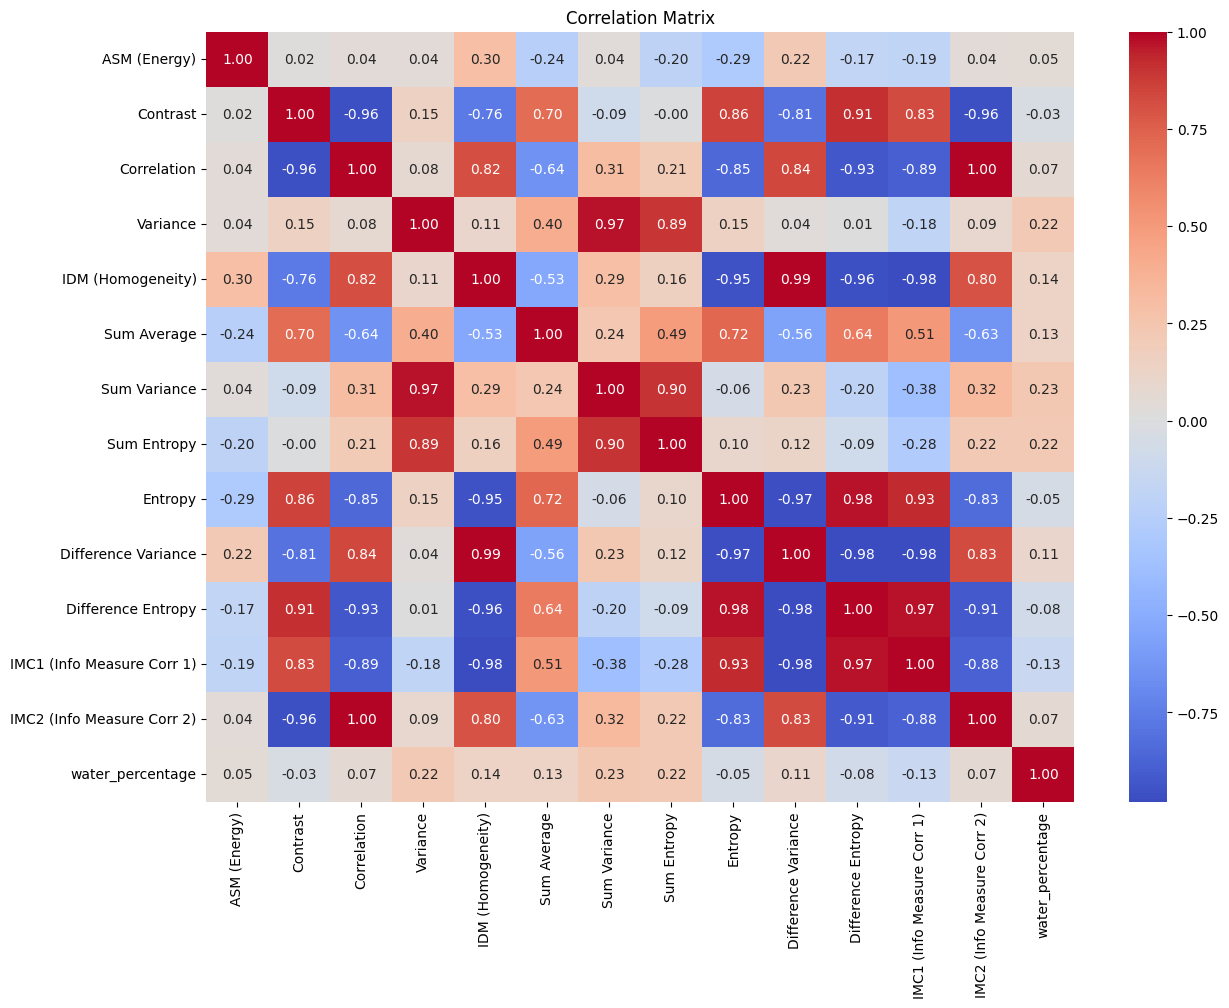

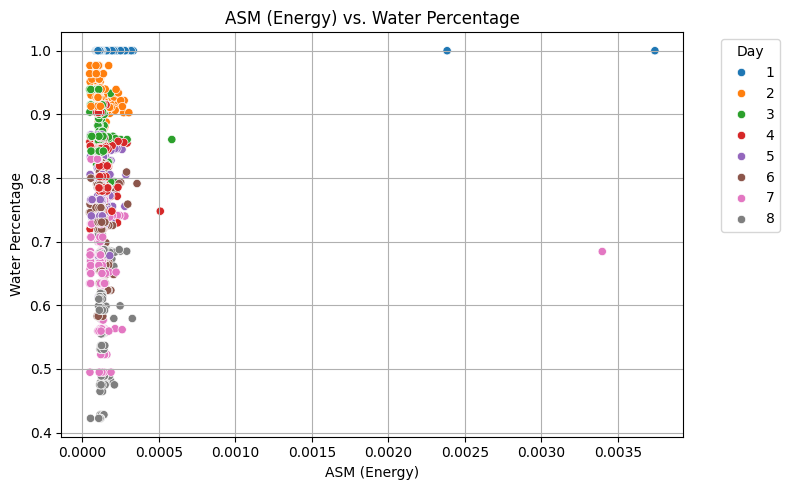

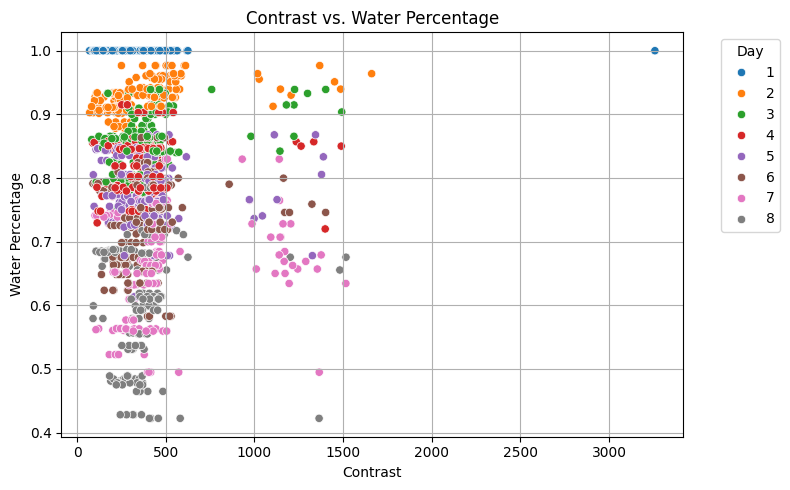

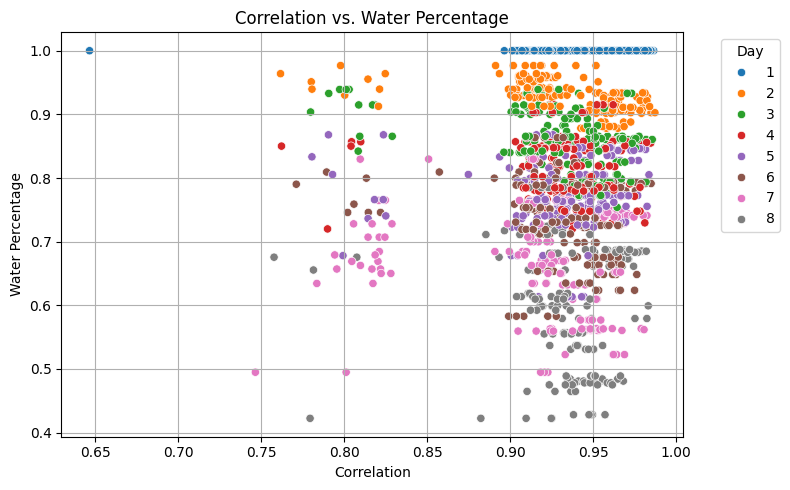

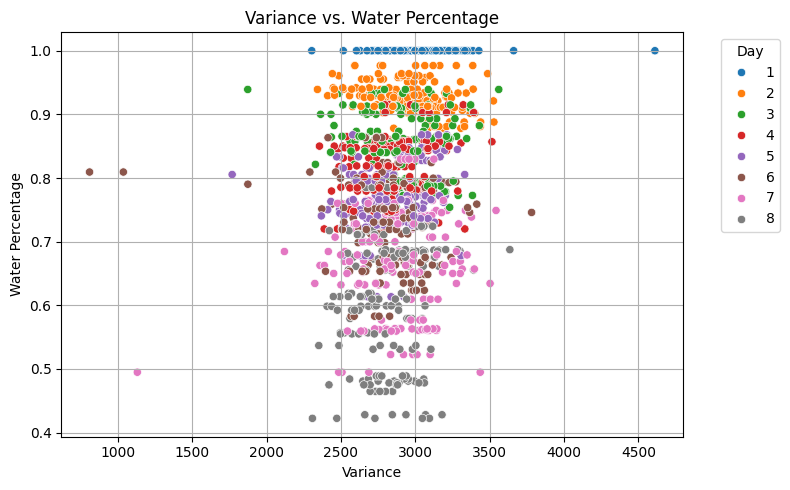

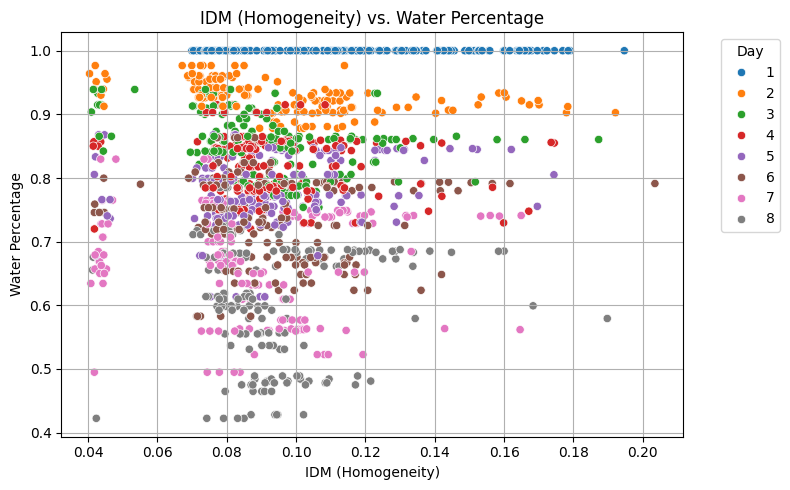

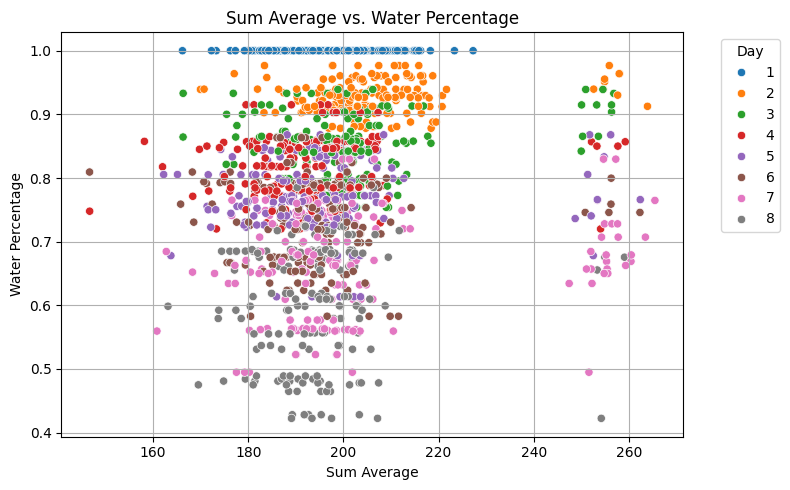

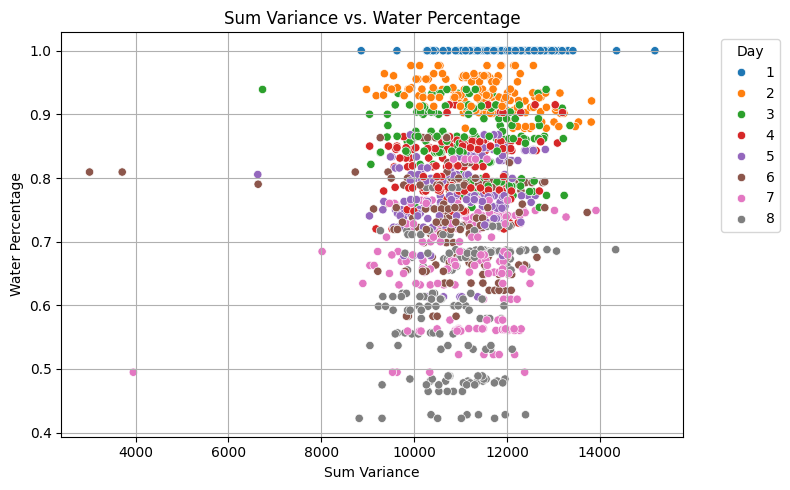

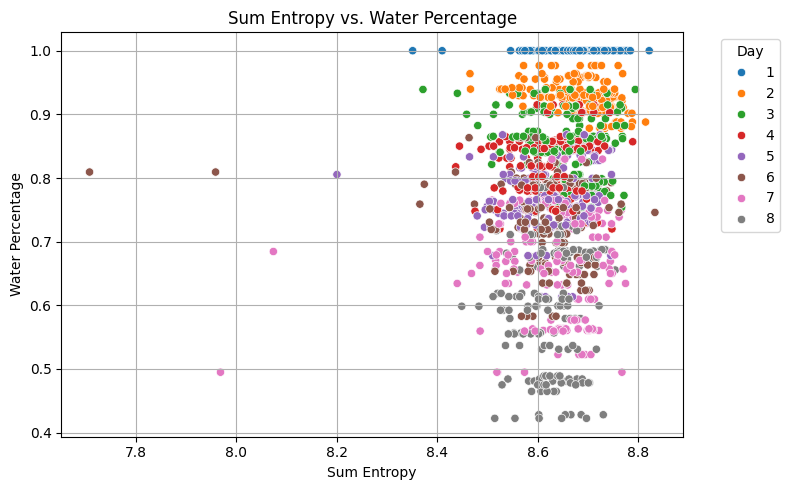

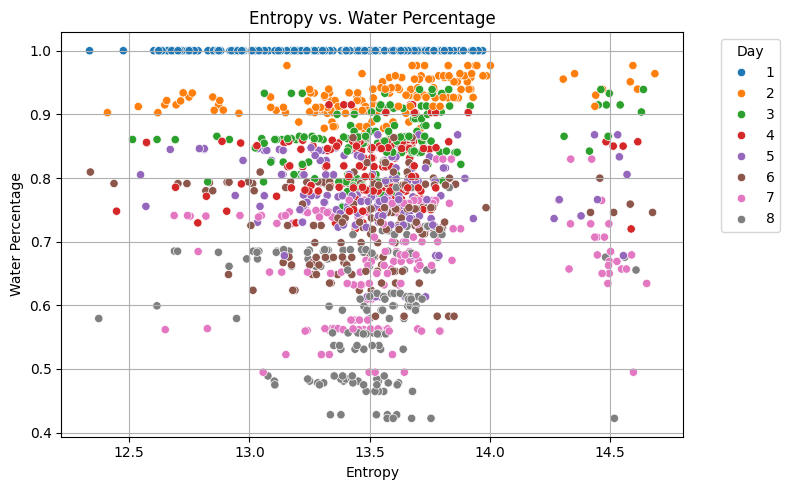

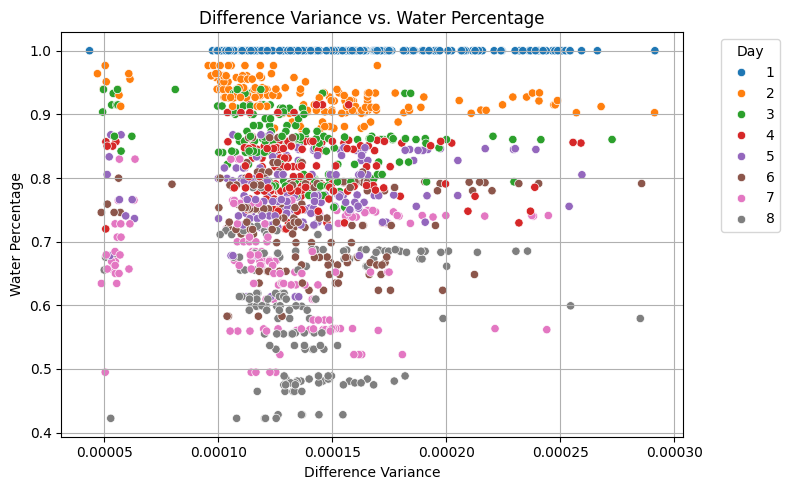

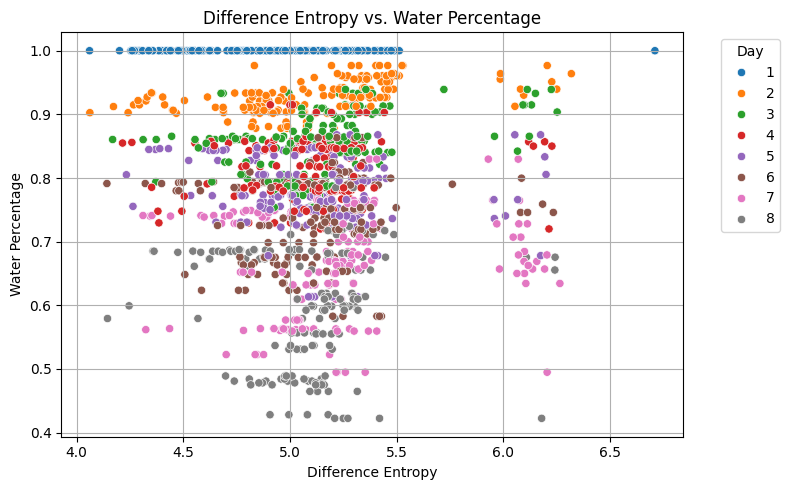

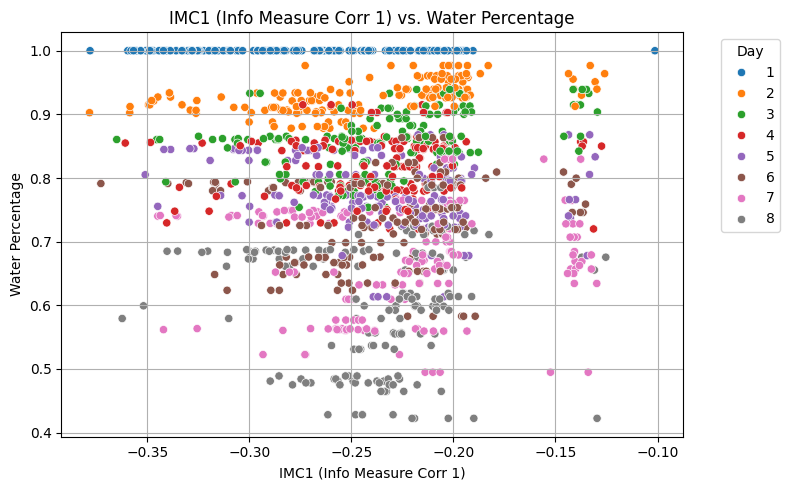

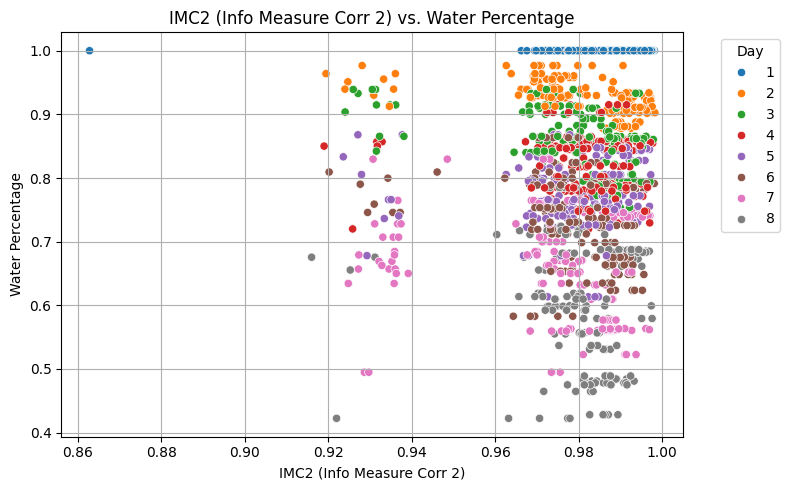

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined dataset (adjust if you already have it in memory)
df = pd.read_excel("C:/Users/ritaj/Documents/R/Rabanitos/datasets/dataset_completo.xlsx")

# --- 1. Overview ---
print("🧩 Dataset dimensions:", df.shape)
print("\n🔍 First rows:")
print(df.head())

# --- 2. General information ---
print("\n📋 Data types:")
print(df.dtypes)

print("\n📊 Descriptive statistics:")
print(df.describe())

# --- 3. Check for missing values ---
print("\n❓ Missing values per column:")
print(df.isnull().sum())

# --- 4. Visualization of water percentage distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df["water_percentage"], bins=20, kde=True)
plt.title("Distribution of Water Percentage")
plt.xlabel("Water Percentage")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# --- 5. Boxplots of Haralick features to detect outliers ---
# List of Haralick features
haralick_features = [
    "ASM (Energy)", "Contrast", "Correlation", "Variance", "IDM (Homogeneity)",
    "Sum Average", "Sum Variance", "Sum Entropy", "Entropy", "Difference Variance",
    "Difference Entropy", "IMC1 (Info Measure Corr 1)", "IMC2 (Info Measure Corr 2)"
]

# Generate an individual boxplot for each feature
for feature in haralick_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

from scipy.stats import zscore

from scipy.stats import zscore

# --- 6. Detect outliers using Z-Score ---
# Compute Z-Scores for Haralick features
z_scores = df[haralick_features].apply(zscore)

# Flag outliers: Z-score above threshold (e.g., 3 or -3)
threshold = 3
outliers_z = (z_scores.abs() > threshold)

# Count outliers per feature
outliers_count = outliers_z.sum()
print("\n🚨 Number of outliers per Haralick feature (|Z| > 3):")
print(outliers_count)

# Create a boolean mask: any feature with Z-score above threshold
df["outlier_zscore"] = outliers_z.any(axis=1)

# Total number of outlier rows
num_outliers = df["outlier_zscore"].sum()
print(f"\n🔎 Total outlier rows (any Haralick feature): {num_outliers}")

# Show the full rows of the detected outliers
print("\n🖼️ Outlier rows (including image names):")
print(df[df["outlier_zscore"]][["Filename"] + haralick_features])



# --- 6. Correlation between features and water percentage ---
plt.figure(figsize=(14, 10))
corr_matrix = df[haralick_features + ["water_percentage"]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# --- 8. Scatter plots of Haralick features vs. Water Percentage, colored by day ---
for feature in haralick_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=feature, y="water_percentage", hue="day", palette="tab10")
    plt.title(f"{feature} vs. Water Percentage")
    plt.xlabel(feature)
    plt.ylabel("Water Percentage")
    plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


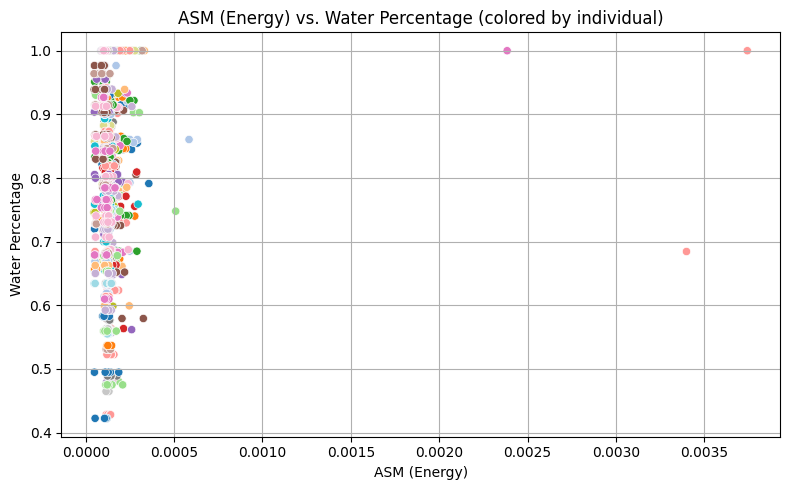

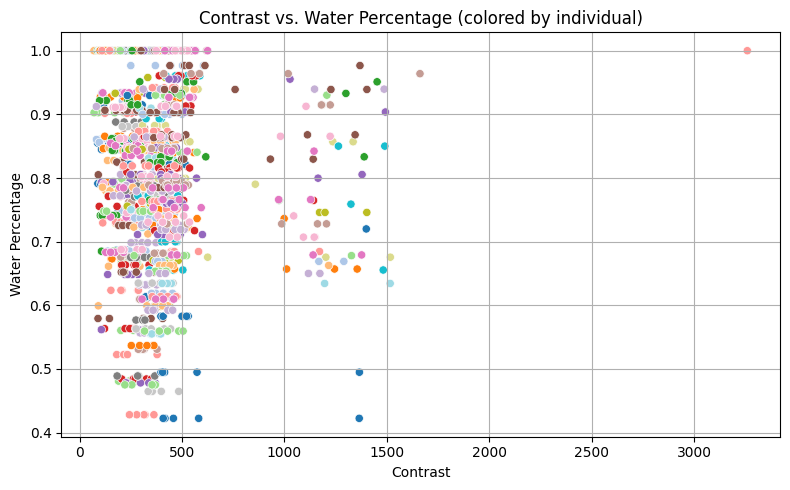

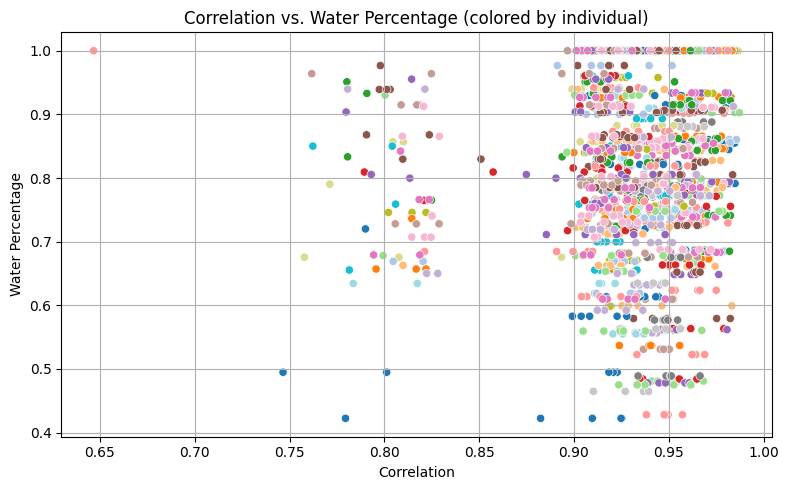

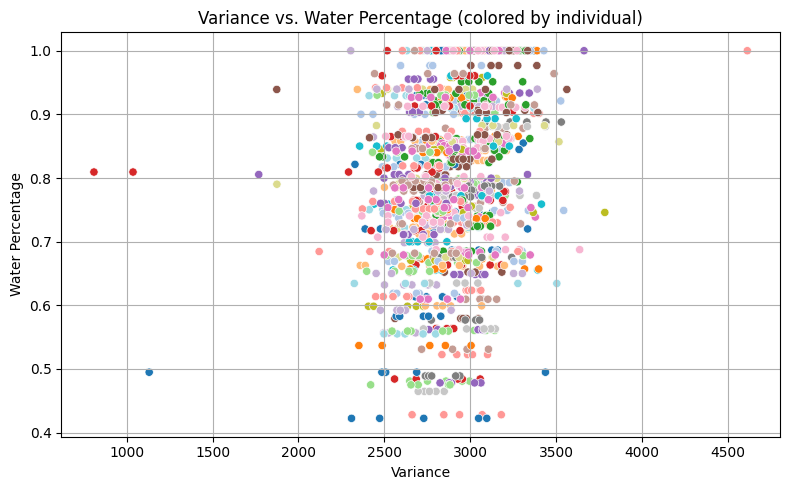

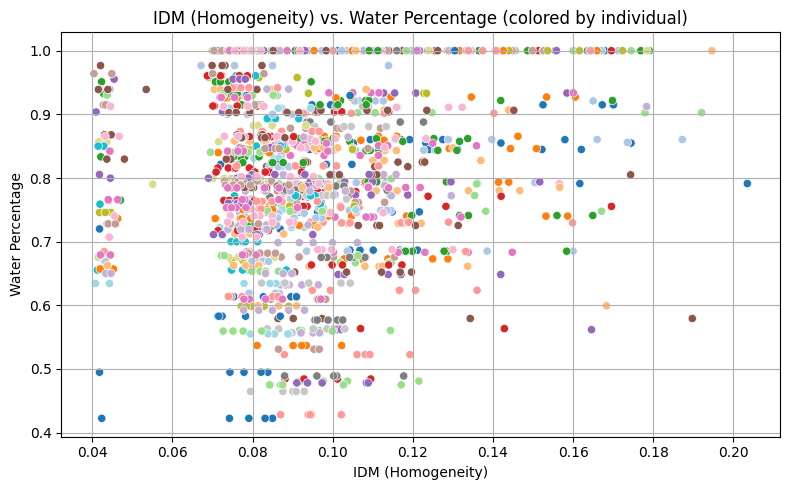

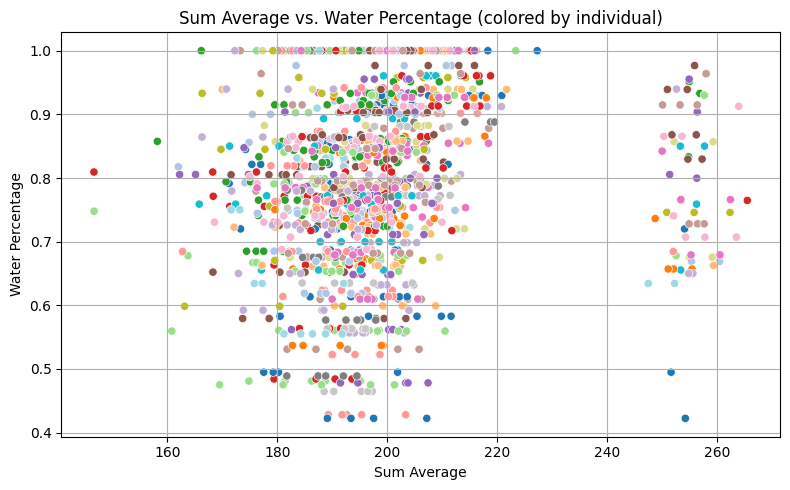

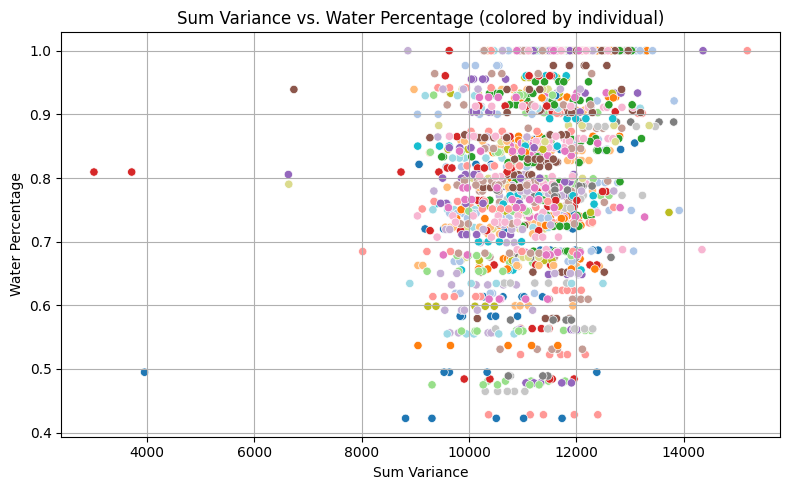

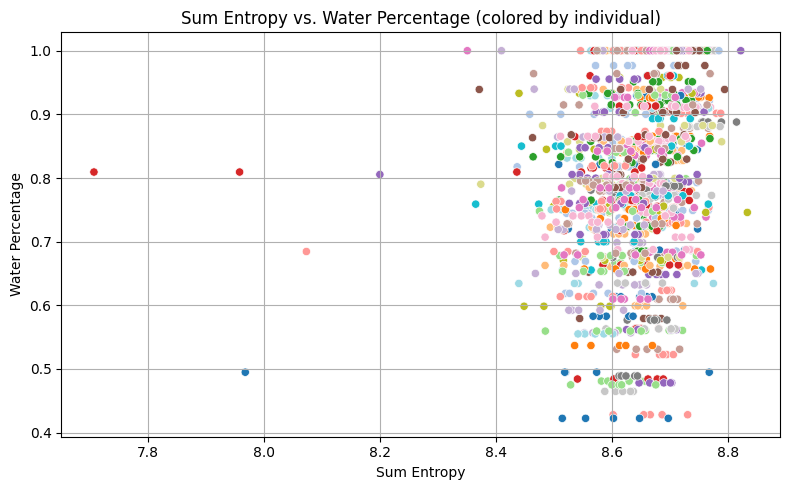

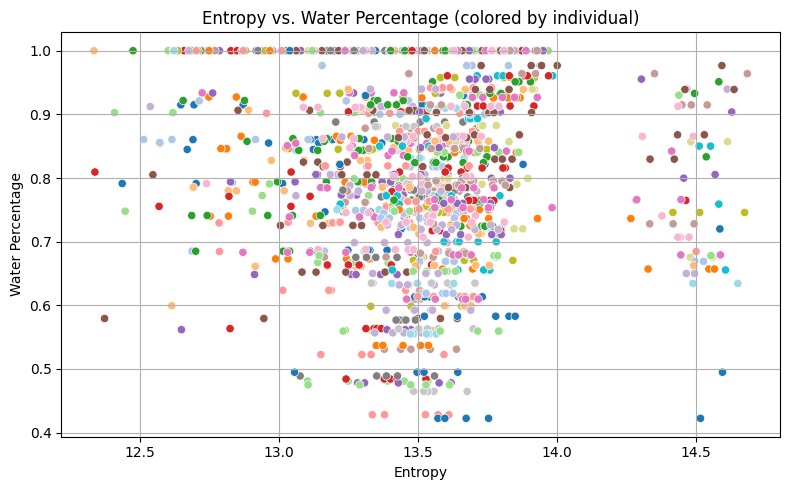

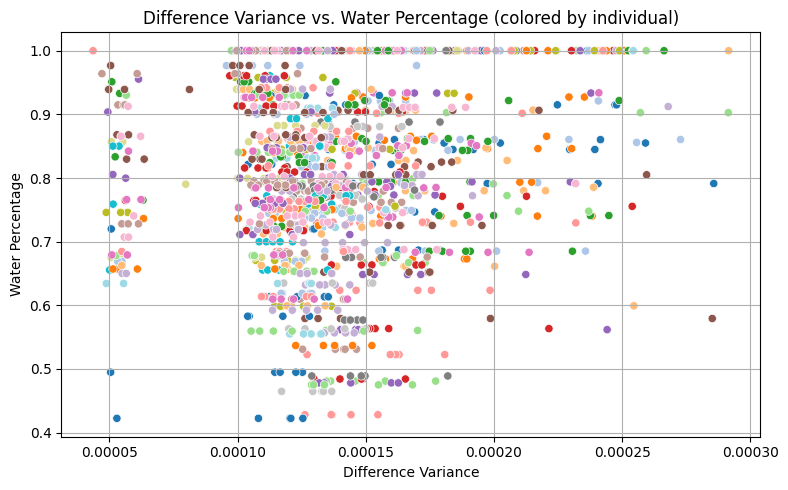

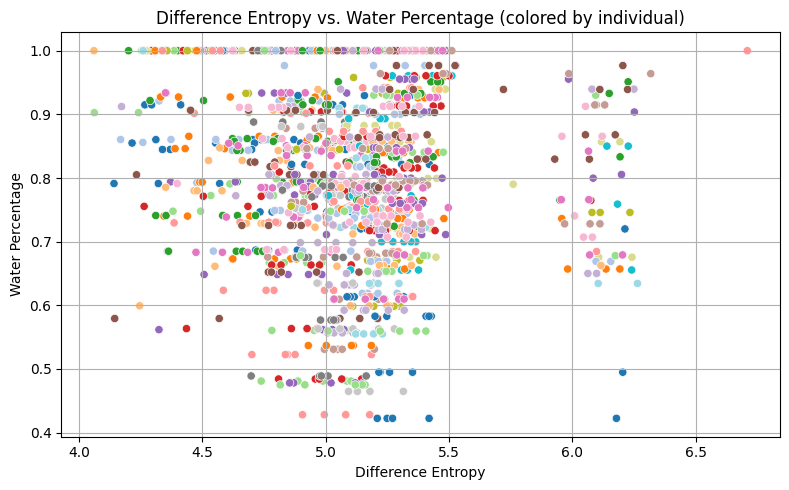

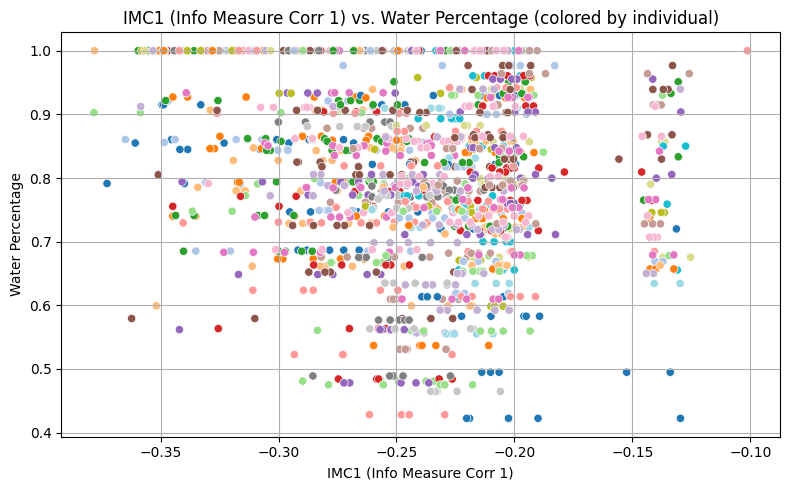

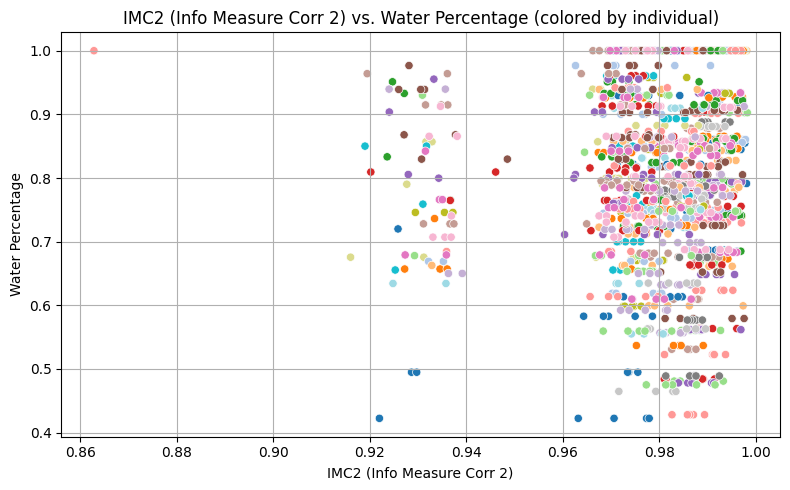

In [2]:
# --- 8. Scatter plots of Haralick features vs. Water Percentage, colored by individual ---
for feature in haralick_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=feature, y="water_percentage", hue="individual", palette="tab20", legend=False)
    plt.title(f"{feature} vs. Water Percentage (colored by individual)")
    plt.xlabel(feature)
    plt.ylabel("Water Percentage")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
